In [1]:
from space.planets import venus
from orbit.pointing import simulation
from orbit.geometry import getTiming
from orbit.envision import loadSV
from measurement.measurement import state_vector

""" System Packages """
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime as dt
import os

In [2]:
sim_folder = os.path.join(r"C:\Users",
                          r"ishuwa.sikaneta",
                          r"OneDrive - ESA",
                          r"Documents",
                          r"ESTEC",
                          r"Envision",
                          r"PointingSimulations")

### Load ESOC-supplied orbit file

In [3]:
sv = loadSV()

# Simulate Pointing Errors

The following class simulates pointing errors for an Envision-type SAR

In [4]:
eSim = simulation(planet = venus(),
                  e_ang = 14.28, # The effective angle of the beam relative to spacecraft coordinate frame
                  azAxis = 5.5,  # The length of the refelector in the azimuth direction. Leads to 0.99 degrees
                  elAxis = 0.6125,  # The length of the reflector in the elevation direction. Leads to 8.9 degrees
                  carrier = 3.15e9)

### Select a subset of state vectors

Select a range of state vectors to use for error simulation

In [5]:
selection_range = [270, 44480, 2]
mysvs = eSim.state(sv.measurementData, selection_range)
 
times = [(sv.measurementTime[k] - sv.measurementTime[0])/np.timedelta64(1, 's') 
         for k in range(*selection_range)]

### Test the simulation of errors

Test right looking configuration with an off-nadir angle of -18.7 and left looking with an off-nadir of 18.7

In [6]:
off_nadir = 18.7

### Define Covariances

Define the set of input covariance matrices for the simulation. These have been determined from the pointing justification document (ESA) and the JPL-provided pointing spreadsheet.

C:\Users\ishuwa.sikaneta\OneDrive - ESA\Documents\ESTEC\sarsim\radar\orbit\euler.py:78: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  Rp = R[k,:,:].dot(M_y)


Norm of u: 1.000000
u*e1: 0.000000
u*e2: 0.947154, v: 0.947210
uP*VP: 0.000000
Roll: 4.4190, Pitch: 0.0012, Yaw: 0.0153
Percent of Doppler centroids in violation: 4.5257


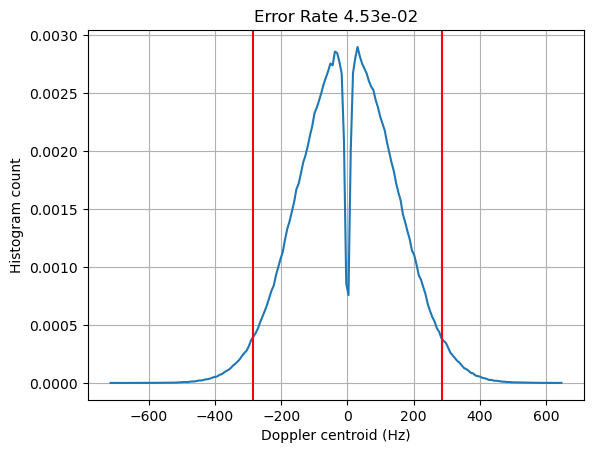

Percent of Swaths in violation: 4.7407


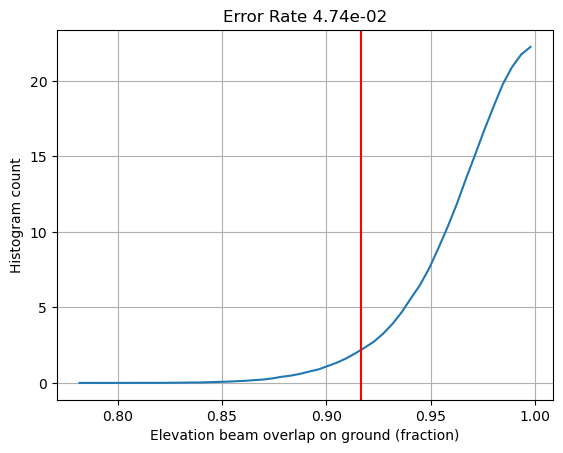

In [7]:
X = mysvs[np.random.randint(0,len(mysvs))]
""" Define the covariances for Thales Alenia Space data """  
covariancesESOCTwoDay = {
    "description": "Covariance matrix errors for TAS consortium",
    "spacecraft": {
        "description": """Errors in the orienting the spacecraft. 
                          These in include star-tracker error, TED, actuator error, 
                          e.t.c.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([1.95e-3, 0.91e-3, 1.22e-3])/2)**2 + #TAS
              (np.diag([11.5e-3, 0.7e-3, 0.7e-3])/2)**2).tolist(), #TAS margin
        },
    "instrument": {
        "description": """Errors marked as TED. 
                          These are assumed to arise from instrument TEDs. 
                          It is assumed there are no other instrument errors.
                          These values from !RequirementSummary of
                          VenSAR_Pointing_Requirements_Table_v5.0.xlsx
                          Note that these come from a pointing requirement and
                          not from CBEs. The CBEs are about 10 percent lower.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([2.39e-3, 0.72e-3, 0.85e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": """Errors in the orbit velocity vector. Although ESOC
                          covariance analysis includes a velocity error, these
                          are highly correlated with position error. Only a small
                          component of the velocity error that lies out-of-plane
                          survives and is included here.
                          Data from:
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx
                          The following is left over from computing the TCNerrorlpy
                          script and subtracting from ESOC values""",
        "referenceVariables": "VtVcVn",
        "units": "m/s",
        "R": ((np.diag([0.3, 0.9, 0.0001])/3)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": """Error in the orbit time (error in orbit angle).
                          These values from the orbit prediction covariance
                          analysis performed by ESOC. 
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.xlsx""",
        "referenceVariables": "t",
        "units": "s",
        "R": (12161/3)**2/np.linalg.norm(X[3:])**2
        },
    "orbitAcrossTrack": {
        "description": """Error in the orbit across track position (orbit tube c and n)
                          Data from covariance analysis performed by ESOC
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx""",
        "referenceVariables": "dCdN",
        "errorDefinition": "TCN",
        "units": "m",
        "R": (np.diag([(847/3)**2, (153/3)**2])).tolist()
        }
    }

res = eSim.simulateError(X, 
                         off_nadir, 
                         covariancesESOCTwoDay,
                         dopErrThreshold = 1/9,
                         eleErrThreshold = 1/12,
                         loglevel=3)

Norm of u: 1.000000
u*e1: -0.000000
u*e2: 0.947201, v: 0.947210
uP*VP: -0.000000
Roll: 4.4198, Pitch: -0.0002, Yaw: -0.0021
Percent of Doppler centroids in violation: 10.0158


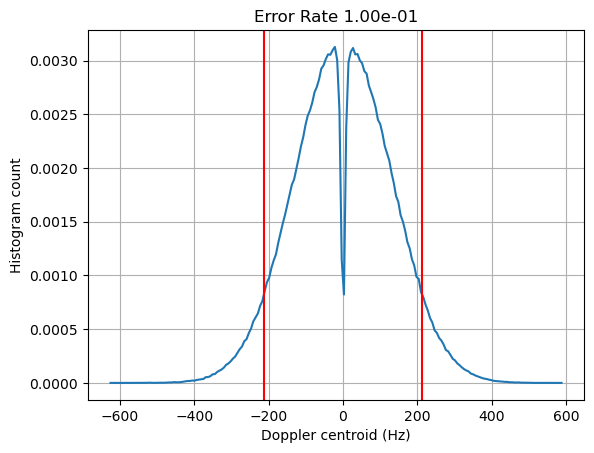

Percent of Swaths in violation: 4.9129


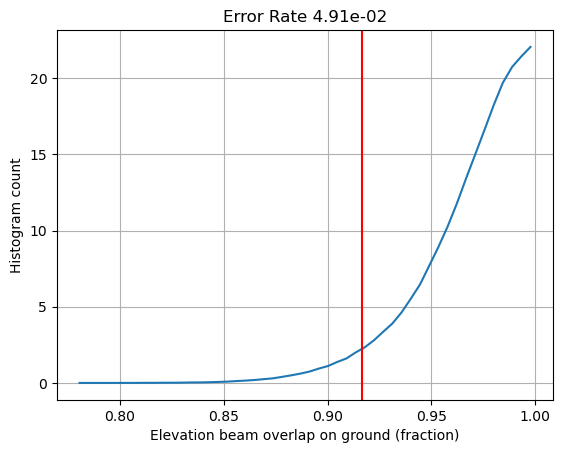

In [9]:
""" Define the covariances with ADS spacecraft data and 1/10 bemawidth for azimuth """  
covariancesESOCTwoDay = {
    "description": "Covariance matrix errors for ADS consortium",
    "spacecraft": {
        "description": """Errors in the orienting the spacecraft. 
                          These in include star-tracker error, TED, actuator error, 
                          e.t.c.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([4.29e-3, 0.83e-3, 0.95e-3])/2)**2 + #ADS
              (np.diag([11.0e-3, 0.3e-3, 0.3e-3])/2)**2).tolist(), #ADS margin
        },
    "instrument": {
        "description": """Errors marked as TED. 
                          These are assumed to arise from instrument TEDs. 
                          It is assumed there are no other instrument errors.
                          These values from !RequirementSummary of
                          VenSAR_Pointing_Requirements_Table_v5.0.xlsx
                          Note that these come from a pointing requirement and
                          not from CBEs. The CBEs are about 10 percent lower.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([2.39e-3, 0.72e-3, 0.85e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": """Errors in the orbit velocity vector. Although ESOC
                          covariance analysis includes a velocity error, these
                          are highly correlated with position error. Only a small
                          component of the velocity error that lies out-of-plane
                          survives and is included here.
                          Data from:
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx
                          The following is left over from computing the TCNerrorlpy
                          script and subtracting from ESOC values""",
        "referenceVariables": "VtVcVn",
        "units": "m/s",
        "R": ((np.diag([0.3, 0.9, 0.0001])/3)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": """Error in the orbit time (error in orbit angle).
                          These values from the orbit prediction covariance
                          analysis performed by ESOC. 
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.xlsx""",
        "referenceVariables": "t",
        "units": "s",
        "R": (12161/3)**2/np.linalg.norm(X[3:])**2
        },
    "orbitAcrossTrack": {
        "description": """Error in the orbit across track position (orbit tube c and n)
                          Data from covariance analysis performed by ESOC
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx""",
        "referenceVariables": "dCdN",
        "errorDefinition": "SwathCentre",
        "units": "m",
        "R": (np.diag([(847/3)**2, (153/3)**2])).tolist()
        }
    }

res = eSim.simulateError(X, 
                         off_nadir, 
                         covariancesESOCTwoDay,
                         dopErrThreshold = 1/12,
                         eleErrThreshold = 1/12,
                         loglevel=3)

Norm of u: 1.000000
u*e1: 0.000000
u*e2: 0.947210, v: 0.947210
uP*VP: -0.000000
Roll: 4.4200, Pitch: 0.0003, Yaw: 0.0042
Percent of Doppler centroids in violation: 4.9089


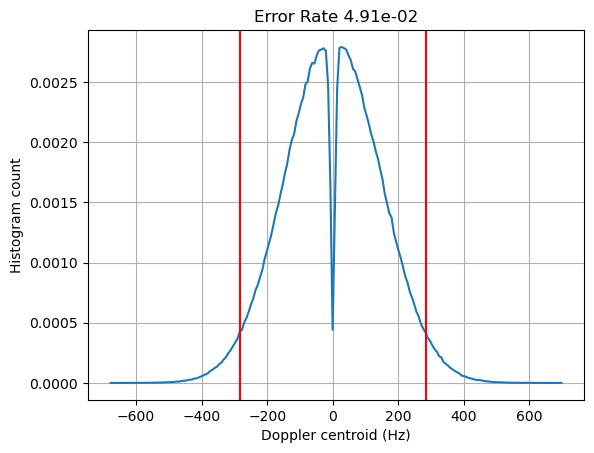

Percent of Swaths in violation: 5.0258


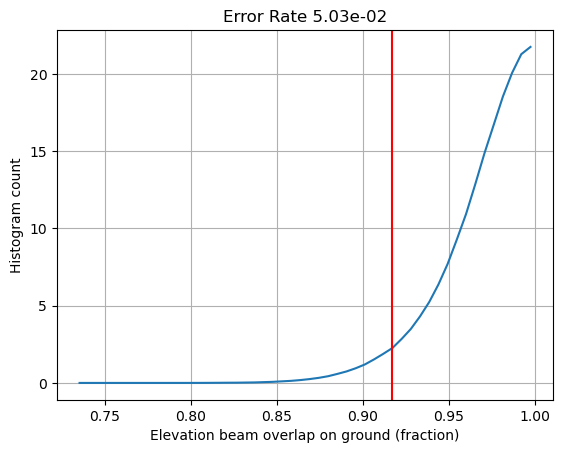

In [9]:
""" Define the covariances with ADS spacecraft data and 1/9 bemawidth for azimuth """  
covariancesESOCTwoDay = {
    "description": "Covariance matrix errors for ADS consortium",
    "spacecraft": {
        "description": """Errors in the orienting the spacecraft. 
                          These in include star-tracker error, TED, actuator error, 
                          e.t.c.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([4.29e-3, 0.83e-3, 0.95e-3])/2)**2 + #ADS
              (np.diag([11.0e-3, 0.9e-3, 0.9e-3])/2)**2).tolist(), #ADS margin
        },
    "instrument": {
        "description": """Errors marked as TED. 
                          These are assumed to arise from instrument TEDs. 
                          It is assumed there are no other instrument errors.
                          These values from !RequirementSummary of
                          VenSAR_Pointing_Requirements_Table_v5.0.xlsx
                          Note that these come from a pointing requirement and
                          not from CBEs. The CBEs are about 10 percent lower.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([2.39e-3, 0.72e-3, 0.85e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": """Errors in the orbit velocity vector. Although ESOC
                          covariance analysis includes a velocity error, these
                          are highly correlated with position error. Only a small
                          component of the velocity error that lies out-of-plane
                          survives and is included here.
                          Data from:
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx
                          The following is left over from computing the TCNerrorlpy
                          script and subtracting from ESOC values""",
        "referenceVariables": "VtVcVn",
        "units": "m/s",
        "R": ((np.diag([0.3, 0.9, 0.0001])/3)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": """Error in the orbit time (error in orbit angle).
                          These values from the orbit prediction covariance
                          analysis performed by ESOC. 
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.xlsx""",
        "referenceVariables": "t",
        "units": "s",
        "R": (12161/3)**2/np.linalg.norm(X[3:])**2
        },
    "orbitAcrossTrack": {
        "description": """Error in the orbit across track position (orbit tube c and n)
                          Data from covariance analysis performed by ESOC
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx""",
        "referenceVariables": "dCdN",
        "errorDefinition": "SwathCentre",
        "units": "m",
        "R": (np.diag([(847/3)**2, (153/3)**2])).tolist()
        }
    }

res = eSim.simulateError(X, 
                         off_nadir, 
                         covariancesESOCTwoDay,
                         dopErrThreshold = 1/9,
                         eleErrThreshold = 1/12,
                         loglevel=3)

In [8]:
""" RPY 2-sigma values from T error ESOC """
R_AEUt = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[3:6,3:6]
print(R_AEUt)
R_RPYt = eSim.aeu2rpyCovariance(R_AEUt)
print(R_RPYt)
print(np.diag(R_RPYt))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYt))*1e3*2)

[[ 4.02210056e-07  1.06849015e-10 -6.66897542e-09]
 [ 1.06849015e-10  2.84185721e-14 -1.77164613e-12]
 [-6.66897542e-09 -1.77164613e-12  1.10577129e-10]]
[[3.54903244e-14 1.03905536e-10 2.46198338e-11]
 [1.03905536e-10 3.80454329e-07 9.01465228e-08]
 [2.46198338e-11 9.01465228e-08 2.13597138e-08]]
[3.54903244e-14 3.80454329e-07 2.13597138e-08]
2-sigma values (Roll, Pitch, Yaw)
[3.76777517e-04 1.23361960e+00 2.92299256e-01]


In [9]:
""" RPY 2-sigma values from velocity errors ESOC """
R_AEUv = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[6:9,6:9]
print(R_AEUv)
R_RPYv = eSim.aeu2rpyCovariance(R_AEUv)
print(R_RPYv)
print(np.diag(R_RPYv))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYv))*1e3*2)

[[4.89108486e-13 3.41408457e-13 2.95809932e-11]
 [3.41408457e-13 2.38321413e-13 2.06491201e-11]
 [2.95809932e-11 2.06491201e-11 1.78912233e-09]]
[[ 2.37906111e-13 -4.75416921e-12  2.00603350e-11]
 [-4.75416921e-12  9.50044671e-11 -4.00873613e-10]
 [ 2.00603350e-11 -4.00873613e-10  1.69149619e-09]]
[2.37906111e-13 9.50044671e-11 1.69149619e-09]
2-sigma values (Roll, Pitch, Yaw)
[0.00097551 0.01949405 0.08225561]


In [10]:
""" RPY 2-sigma values from across-track and radial errors ESOC """
R_AEUp = np.array([[0,0,0],
                  [0,res["computed"]["ErrorCovariance"]["BlockCovariance"][9][9],0],
                  [0,0,0]])
print(R_AEUp)
R_RPYp = eSim.aeu2rpyCovariance(R_AEUp)
print(R_RPYp)
print(np.diag(R_RPYp))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYp))*1e3*2)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.30824507e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[6.34552175e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[6.34552175e-08 0.00000000e+00 0.00000000e+00]
2-sigma values (Roll, Pitch, Yaw)
[0.50380638 0.         0.        ]


In [11]:
""" RPY 2-sigma values from instrument JPL """
R_AEUi = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[10:13,10:13]
print(R_AEUi)
R_RPYi = eSim.aeu2rpyCovariance(R_AEUi)
print(R_RPYi)
print(np.diag(R_RPYi))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYi))*1e3*2)

[[ 1.32564355e-07 -2.90014728e-09  1.20225140e-08]
 [-2.90014728e-09  1.43569885e-06  2.75106149e-09]
 [ 1.20225140e-08  2.75106149e-09  1.77393541e-07]]
[[ 1.44527012e-06 -6.11357655e-09 -2.41514714e-09]
 [-6.11357655e-09  1.29591882e-07  3.17914522e-10]
 [-2.41514714e-09  3.17914522e-10  1.81509844e-07]]
[1.44527012e-06 1.29591882e-07 1.81509844e-07]
2-sigma values (Roll, Pitch, Yaw)
[2.40438776 0.71997745 0.85207944]


In [23]:
""" Old way of computing ephemeris cross and radial error """
v = np.array([np.sin(np.radians(res["given"]["off_nadir"])), 
              np.cos(np.radians(res["given"]["off_nadir"]))])
RAEUat = np.zeros((3,3))
#from measurement.measurement import state_vector
mysv = state_vector(planet = venus())
mysv.add(np.datetime64("2000-01-01T00:00:00.000000"), sv.toPCR(X, 0))
r, rhat, inc, _, _ = getTiming(sv, [np.radians(off_nadir)], 0)
sigma_e_sqr = v.T.dot(np.array(covariancesESOCTwoDay["orbitAcrossTrack"]["R"])).dot(v)/r[0]**2
print(2*np.sqrt(sigma_e_sqr)*1e3)

0.7956137354420149


In [24]:
tcn = eSim.tcnFromX(X)
print(tcn)
print(rhat)
print(v)
print(tcn.dot(rhat[0]))
t = X[3:]/np.linalg.norm(X[3:])
print(rhat[0].dot(t))
print(inc)

[[ 0.15567906 -0.34676764 -0.92494121]
 [ 0.09700913  0.93719833 -0.33503509]
 [ 0.98303268 -0.03756979  0.17954179]]
[[-0.38863873 -0.3657687  -0.84567913]]
[0.32061299 0.94721028]
[ 0.84853731 -0.09716714 -0.52013746]
-0.9273160445450017
[19.47544874]


In [17]:
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYt+R_RPYv+R_RPYp))*1e3*2)

2-sigma values (Roll, Pitch, Yaw)
[1.19869993 1.22829813 0.30256811]


In [18]:
print("2-sigma values (Azimuth, Elevation, Tilt)")
print(np.sqrt(np.diag(R_AEUt+R_AEUv+R_AEUp))*1e3*2)

2-sigma values (Azimuth, Elevation, Tilt)
[1.26267274 1.19785896 0.08888817]


In [18]:
print(json.dumps(res, indent=2))

{
  "given": {
    "off_nadir": 18.7,
    "azAxis": 5.5,
    "elAxis": 0.6125,
    "carrier": 3150000000.0,
    "covariances": {
      "description": "Covariance matrix errors for ADS consortium",
      "spacecraft": {
        "description": "Errors in the orienting the spacecraft. \n                          These in include star-tracker error, TED, actuator error, \n                          e.t.c.",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": [
          [
            3.4851025e-05,
            0.0,
            0.0
          ],
          [
            0.0,
            3.74725e-07,
            0.0
          ],
          [
            0.0,
            0.0,
            4.2812500000000003e-07
          ]
        ]
      },
      "instrument": {
        "description": "Errors marked as TED. \n                          These are assumed to arise from instrument TEDs. \n                          It is assumed there are no other instrument errors.\